In [103]:
import matplotlib.pyplot as plt
import numpy as np

import finesse
from finesse.analysis.actions import Xaxis
finesse.init_plotting()

base = finesse.Model()

base.parse(""" 
l LI P=125
s s1 LI.p1 PRM.p1 L=0

# Power recycling mirror
m PRM T=0.03 L=37.5u phi=90
s prc PRM.p2 bs1.p1 L=53

# Central beamsplitter
bs bs1 R=0.5 T=0.5 phi=0 alpha=45

# X-arm
s sx bs1.p3 ITMX.p1 L=4.5
m ITMX T=0.014 L=37.5u phi=89.997
s Lx ITMX.p2 ETMX.p1 L=3995
m ETMX T=0.014 L=37.5u phi=89.997
s x_length ETMX.p2 scatter.p1 L=1
m scatter T=0.995 L=37.5u phi=89.997

# Y-arm
s sy bs1.p2 ITMY.p1 L=4.45
m ITMY T=0.014 L=37.5u phi=3m
s Ly ITMY.p2 ETMY.p1 L=3995
m ETMY T=0.014 L=37.5u phi=3m


# Signal recycling mirror
s src bs1.p4 SRM.p1 L=50.525
m SRM T=0.2 L=37.5u phi=-90

# These commands give the mirrors a mass
# by default they are infinitely heavy
free_mass ITMX_sus ITMX.mech mass=40
free_mass ETMX_sus ETMX.mech mass=40
free_mass ITMY_sus ITMY.mech mass=40
free_mass ETMY_sus ETMY.mech mass=40
""") 

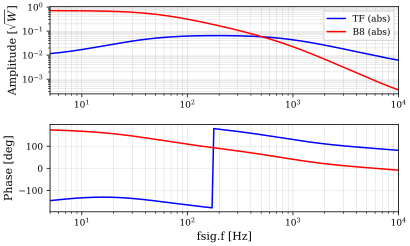

In [104]:
# Computes the gravitational wave signal transfer function to the output of a detector.    

# specifying our frequency range for future use
fstart = 5
fstop = 1e4
Npoints = 200

# This makes a copy of the model so we can add new commands to it
# without changing the original, which we will reuse
ifo = base.deepcopy() 
ifo.parse(f"""
fsig(1)
sgen sig1 scatter.mech.z .05 0
pd1 TF SRM.p2.o f=fsig.f
pd1 B8 scatter.p1.i f=fsig.f
""")

out = ifo.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))
    
# We store the frequency and magnitude of the transfer function [W/h]
# (In general we need to store the magnitude and phase of the transfer 
# functions but we only need the magniture for these examples.)
f = out.x1
Hs_TF = np.abs(out['TF'])
Hs_B8 = np.abs(out['B8'])

"""
plt.loglog(f, Hs_TF)
plt.loglog(f, Hs_B8)
plt.show()
"""

out.plot(log=True)
plt.show()

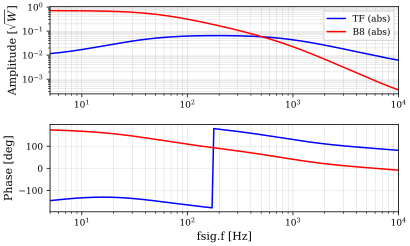

In [105]:
# We can write a function to model a transfer function from different inputs 
# to keep our code compact. We use the table above to find the `fsig` command to 
# modulate the mirror position in units of [W/m].

# Computer transfer function from a specific input node to a photo detector in the 
# main interferometer outout
def get_TF(base, input_node):
    ifo = base.deepcopy()
    ifo.parse(f"""
    fsig(1)
    sgen sig1 {input_node} .05 0
    pd1 TF SRM.p2.o f=fsig.f
    pd1 B8 scatter.p1.i f=fsig.f
    """)
    return ifo.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))

mirrors = ['ETMX', 'ETMY', 'ITMX', 'ITMY']

tfs = np.empty([len(mirrors),len(f)])

for i,m in enumerate(mirrors):
    out = get_TF(base, f'{m}.mech.z')
    tfs[i]=np.abs(out['TF'])


out = get_TF(base, 'scatter.mech.z')
# Plotting one TF to see how it looks
out.plot(log=True)
plt.show()

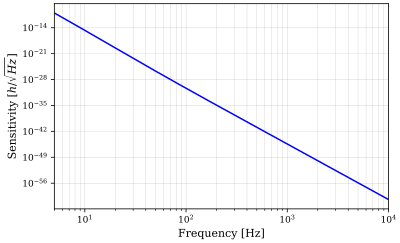

In [106]:
# We compute an expected frequency spectrum of the mirror motion along the optical axis 
# due to seismic noise using this simple model (note that this is an arbitrary noise
# spectrum for demonstration purposed and does not represent any actual noise measurement.)
def seismic_noise_ASD(f):
    f = np.array(f)
    N = 1e-4/np.abs(np.random.normal(f**15, 0, size=f.size))
    return N

N_s_asd = seismic_noise_ASD(f)

# Computing the seismic noise limited sensitivity.
# (adding amplitude spectral densities A, B, and C, works as sqrt(A^2 + B^2 + C^2).
sum = 0
for tf in tfs:
    sum += (N_s_asd * tf / Hs_TF)**2
S_s = np.sqrt(sum)

# Plotting the 'seismic-limited sensitivity'
plt.figure()
plt.loglog(f, S_s)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\\sqrt{Hz}$]")
plt.show()

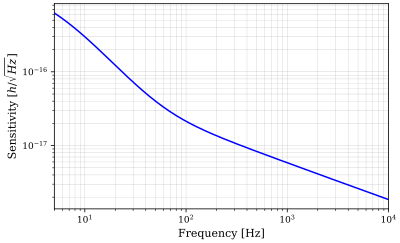

In [107]:
# A simple model for thermal noise, again only used 
def thermal_noise_ASD(f):
    """
    Based on https://arxiv.org/pdf/gr-qc/0109073.pdf equation 24
    """
    kb = 1.38064852e-23
    T = 300
    Y = 7e10
    d = 5e-6
    w = 5e-2
    phi = 1e-5
    phi_s = 1e-8
    return np.sqrt(2*kb * T/((np.pi)**(3/2)*f) * (1/(w*Y))* (phi_s + 1/np.sqrt(np.pi) * d/w * 2* phi ))/np.sqrt(2)

N_t_asd = thermal_noise_ASD(f)

# Here we compute the thermal noise limited sensitivity
sum = 0
for tf in tfs:
    sum += (N_t_asd * tf / Hs_TF)**2
S_t = np.sqrt(sum)

plt.figure()
plt.loglog(f, S_t)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\\sqrt{Hz}$]")
plt.show()

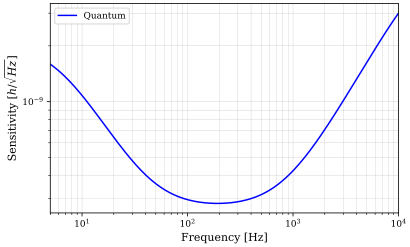

In [108]:
ifo = base.deepcopy()
ifo.parse(f"""
fsig(1)
# compute the quantum-noise in the detector output
qnoised qn SRM.p2.o
""")
#ifo.LI.P=10
out = ifo.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))

S_q = out['qn'] / Hs_TF

plt.loglog(f, S_q, label="Quantum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\\sqrt{Hz}$]")
plt.legend()
plt.tight_layout()
plt.show()

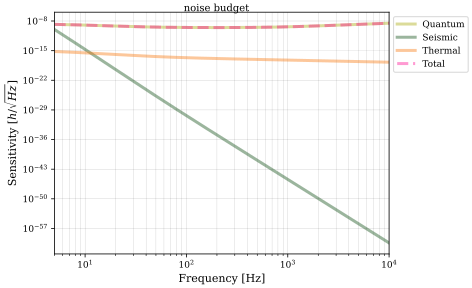

In [109]:
#all curves together:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.loglog(f, S_q, label="Quantum", alpha=0.4, color='xkcd:puke', linewidth=3)
ax.loglog(f, S_s, label="Seismic",alpha=0.4, color='xkcd:forest green', linewidth=3)
ax.loglog(f, S_t, label="Thermal",alpha=0.4, color='xkcd:orange', linewidth=3)

total = np.sqrt(S_q**2 + S_s**2 + S_t**2)
ax.loglog(f, total, label="Total", alpha=0.4, color='xkcd:electric pink', linewidth=3, linestyle='--')

#ax.set_ylim(1e-24, 1e-21)
ax.legend(loc=2,bbox_to_anchor=(1,1))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Sensitivity [$h/\\sqrt{Hz}$]")
fig.suptitle('noise budget')
fig.subplots_adjust(top=0.95)
plt.show()

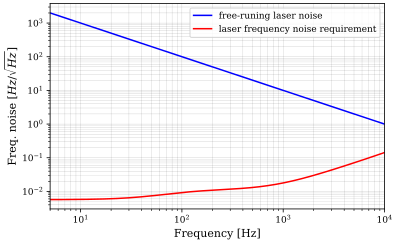

In [110]:
ifo = base.deepcopy()

out = get_TF(ifo, 'LI.frq')
Hn = np.abs(out['TF'])

# Simple model of frequency noise (ultra-stable but free-running laser)
def frequency_noise_ASD(f):
    f = np.array(f)
    return 1e4/abs(np.random.normal(f, 0, size=f.size))
    
N_f = frequency_noise_ASD(f)

# The same equation as above but inverted to compute the frequency noise from 
# 'total', the sensitivity computed above.
N_f_req = total * Hs_TF / Hn

plt.figure()
plt.loglog(f, N_f, label="free-runing laser noise")
plt.loglog(f, N_f_req, label="laser frequency noise requirement")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Freq. noise [$Hz/\\sqrt{Hz}$]")
plt.show()